In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import cirq
from xmps.iMPS import iMPS, Map
from qmps.represent import get_env_exact, FullStateTensor, Environment
from qmps.tools import unitary_to_tensor, environment_from_unitary
from scipy.linalg import expm
from qmps.ground_state import Hamiltonian
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('pub_fast')
from qmps.represent import ShallowFullStateTensor
from qmps.tools import tensor_to_unitary, environment_to_unitary
from qmps.rotosolve import gate as gate_
from scipy.linalg import null_space, norm
from tqdm import tqdm_notebook
from xmps.spin import paulis
from qmps.represent import ShallowFullStateTensor
from qmps.tools import tensor_to_unitary
from qmps.rotosolve import gate
from scipy.linalg import null_space
from xmps.tensor import rotate_to_hermitian
I, X, Y, Z = np.eye(2), *paulis(0.5)
def merge(A, B):
    # -A- -B-  ->  -A-B-
    #  |   |        ||
    return np.tensordot(A, B, [2, 1]).transpose([0, 2, 1, 3]).reshape(2*A.shape[0], 2, 2)

def Nsphere(v):
    # Spherical coordinates for the (len(v)-1)-sphere
    def sts(v):
        # [a, b, c..] -> [[a], [a, b], [a, b, c], ..]
        return [np.array(v[:b]) for b in range(1, len(v)+1)]
    def cs(v):
        # [[a], [a, b], [a, b, c], ..] -> [prod([cos(a)]), prod([sin(a), cos(b)]), ...]
        return np.prod(np.array([*np.sin(v[:-1]), np.cos(v[-1])]))
    def ss(v):
        # same as cs but with just sines
        return np.prod(np.sin(v))
    return np.array([cs(v) for v in sts(v)]+[ss(v)])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def put_env_on_left_site(q, ret_n=False):
    # Take a matrix q (2x2) and create U such that 
    # (right 0-|---|--0
    #          | u |        =  q_{ij}
    # (left) i-|---|--j 
    q = q.T
    a, b, c, d = q.reshape(-1)
    n = np.sqrt(np.abs(a)**2+ np.abs(c)**2+ np.abs(b)**2+ np.abs(d)**2)
    guess = np.array([[a, c.conj(), b, d.conj()], [c, -a.conj(), d, -b.conj()]])/n
    orth = null_space(guess).conj().T
    A = np.concatenate([guess, orth], axis=0)
    A = cirq.unitary(cirq.SWAP)@A
    if ret_n:
        return A, n
    else:
        return A
def get_env_off_left_site(A):
    z = np.array([1, 0])
    return np.tensordot(np.tensordot(A.reshape(2, 2, 2, 2), z, [3, 0]), z, [1, 0]).T

def put_env_on_right_site(q, ret_n=False):
    q = q
    a, b, c, d = q.reshape(-1)
    n = np.sqrt(np.abs(a)**2+ np.abs(c)**2+ np.abs(b)**2+ np.abs(d)**2)
    guess = np.array([[a, b, d.conj(), -c.conj()], [c, d, -b.conj(), a.conj()]])/n
    orth = null_space(guess).conj().T
    A = np.concatenate([guess, orth], axis=0)
    #A = cirq.unitary(cirq.SWAP)@A
    if ret_n:
        return A, n
    else:
        return A

def get_env_off_right_site(A):
    z = np.array([1, 0])
    return np.tensordot(np.tensordot(A.reshape(2, 2, 2, 2), z, [2, 0]), z, [0, 0])


N = 50
for _ in range(50):
    q = np.random.randn(2, 2)+1j*np.random.randn(2, 2)
    assert np.allclose(get_env_off_left_site(np.prod(put_env_on_left_site(q, ret_n=True))), q)
    assert np.allclose(get_env_off_right_site(np.prod(put_env_on_right_site(q, ret_n=True))), q)
    U = put_env_on_left_site(q)
    V = put_env_on_right_site(q)
    assert np.allclose(V.conj().T@V, np.eye(U.shape[0]))
    assert np.allclose(U.conj().T@U, np.eye(U.shape[0]))
    
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    B = iMPS().random(2, 2).left_canonicalise()[0]#np.tensordot(expm(-1j*Z*dt), A, [1, 0])

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    x, r = Map(merge(A, A), merge(B, B)).right_fixed_point()
    x_, l = Map(merge(A, A), merge(B, B)).left_fixed_point()
    L = put_env_on_right_site(l)
    R = put_env_on_left_site(r)
    assert np.allclose(get_env_off_left_site(put_env_on_left_site(r)), r)
    assert np.allclose(get_env_off_right_site(put_env_on_right_site(l)), l)
    U = put_env_on_left_site(r)
    V = put_env_on_right_site(l)
    assert np.allclose(V.conj().T@V, np.eye(U.shape[0]))
    assert np.allclose(U.conj().T@U, np.eye(U.shape[0]))

In [6]:
from scipy.linalg import norm
A = iMPS().random(2, 2).left_canonicalise()[0]
B = iMPS().random(2, 2).left_canonicalise()[0]#np.tensordot(expm(-1j*Z*dt), A, [1, 0])

E = Map(A, B)
E_ = E.full_matrix()
x, r = E.left_fixed_point()
v = np.concatenate([r.reshape(-1).real, r.reshape(-1).imag])

def obj(vector):
    a, b = np.split(vector, 2)
    ψ = a+1j*b
    ψ/=norm(ψ)
    return -norm(E.mv(ψ))

res = minimize(obj, np.random.randn(8))

print(obj(v), np.abs(E.left_fixed_point()[0]))

-0.8693027885668937 [0.68686845]


In [381]:
N = 10
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    B = iMPS().random(2, 2).left_canonicalise()[0]#np.tensordot(expm(-1j*Z*dt), A, [1, 0])

    E = Map(A, B)

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()


    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(l.conj().T), 'L')


    qbs = cirq.LineQubit.range(4)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[1]), cirq.CNOT(*qbs[1:3]), 
                                   R(*qbs[2:]),
                                   g[0](qbs[1]),
                                   cirq.CNOT(*qbs[1:3]), cirq.H(qbs[1])])
        s = cirq.Simulator()
        assert np.allclose(2*s.simulate(C).final_state[0]-np.trace(g[1]@r), 0, 1e-6, 1e-6)
    # r is the matrix on the 1st qubit

    qbs = cirq.LineQubit.range(4)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[1]), cirq.CNOT(*qbs[1:3]),
                                   U(*qbs[0:2]),
                                   R(*qbs[2:]),
                                   g[0](qbs[0]),
                                   cirq.inverse(U_)(*qbs[0:2]),
                                   cirq.CNOT(*qbs[1:3]), cirq.H(qbs[1])])
        s = cirq.Simulator()
        assert np.allclose(2*s.simulate(C).final_state[0]-x*np.trace(g[1]@r), 0, 1e-6, 1e-6)

    qbs = cirq.LineQubit.range(5)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[2]), cirq.CNOT(*qbs[2:4]),
                                   U(*qbs[1:3]),
                                   U(*qbs[0:2]),
                                   R(*qbs[3:]),
                                   g[0](qbs[0]),
                                   cirq.inverse(U_)(*qbs[0:2]),
                                   cirq.inverse(U_)(*qbs[1:3]),
                                   cirq.CNOT(*qbs[2:4]), cirq.H(qbs[2])])
        s = cirq.Simulator()
        #print(C.to_text_diagram(transpose=True))
        #raise Exception
        assert np.allclose(2*s.simulate(C).final_state[0]-x**2*np.trace(g[1]@r), 0, 1e-6, 1e-6)


    qbs = cirq.LineQubit.range(3)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[1]), cirq.CNOT(*qbs[1:3]), 
                                   L(*qbs[:2]),
                                   g[0](qbs[2]),
                                   cirq.CNOT(*qbs[1:3]), cirq.H(qbs[1])])
        s = cirq.Simulator()

        assert np.allclose(2*s.simulate(C).final_state[0]-np.trace(g[1]@l.conj()), 0, 1e-6, 1e-6)
    # r is the matrix on the 1st qubit

    qbs = cirq.LineQubit.range(4)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[2]), cirq.CNOT(*qbs[2:4]),
                                   U(*qbs[1:3]),
                                   L(*qbs[:2]),
                                   g[0](qbs[3]),
                                   cirq.inverse(U_)(*qbs[1:3]),
                                   cirq.CNOT(*qbs[2:4]), cirq.H(qbs[2])])
        s = cirq.Simulator()
        #print(C.to_text_diagram(transpose=True))
        #raise Exception
        assert np.allclose(2*s.simulate(C).final_state[0]-x*np.trace(g[1]@l.conj()), 0, 1e-6, 1e-6)

    qbs = cirq.LineQubit.range(5)
    for g in zip([cirq.I, cirq.X, cirq.Y, cirq.Z], [I, X, Y, Z]):
        C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                                   U(*qbs[2:4]),
                                   U(*qbs[1:3]),
                                   L(*qbs[0:2]),
                                   g[0](qbs[4]),
                                   cirq.inverse(U_)(*qbs[1:3]),
                                   cirq.inverse(U_)(*qbs[2:4]),
                                   cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
        s = cirq.Simulator()
        assert np.allclose(2*s.simulate(C).final_state[0]-x**2*np.trace(g[1]@l.conj()), 0, 1e-6, 1e-6)

    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    s = cirq.Simulator()
    assert np.allclose(2*s.simulate(C).final_state[0], x**2*np.trace(l.conj().T@r))

<IPython.core.display.Javascript object>


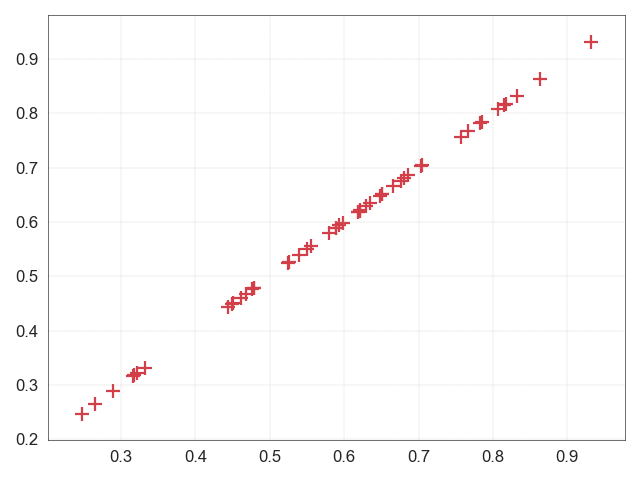

In [36]:
fids = []
N = 50
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    B = iMPS().random(2, 2).left_canonicalise()[0]#np.tensordot(expm(-1j*Z*dt), A, [1, 0])

    E = Map(A, B)

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()


    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(l.conj().T), 'L')
    
    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    
    qbs = cirq.LineQubit.range(4)
    normC = cirq.Circuit.from_ops([cirq.H(qbs[1]),
                                   cirq.CNOT(*qbs[1:3]),
                                   L(*qbs[:2]),
                                   R(*qbs[-2:]),
                                   cirq.CNOT(*qbs[1:3]), 
                                   cirq.H(qbs[1])])
    s = cirq.Simulator()
    fids.append([s.simulate(C).final_state[0]/s.simulate(normC).final_state[0], x[0]**2])
fids = np.array(fids)
plt.figure()
plt.scatter(np.abs(fids[:, 0]), np.abs(fids[:, 1]), marker='+');

<IPython.core.display.Javascript object>


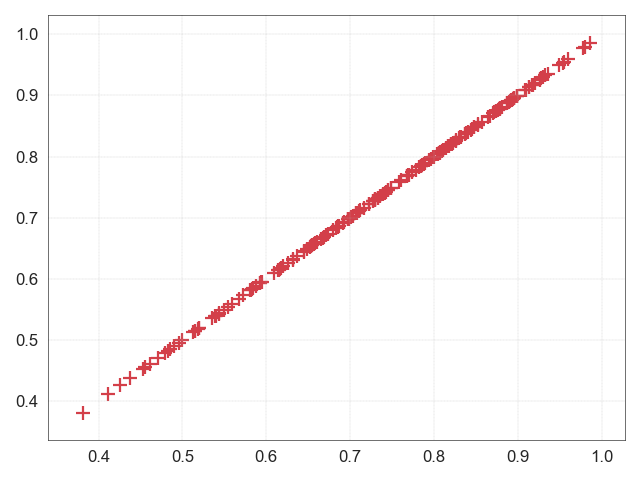

In [8]:
plt.figure()
fids = []
N = 200
dt = 5
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    #B = np.tensordot(expm(-1j*Z*dt), A, [1, 0])
    B = iMPS().random(2, 2).left_canonicalise()[0]
    #BB = np.tensordot(expm(-1j*Hamiltonian({'ZZ':-1, 'X':1}).to_matrix()*dt), merge(, B), [1, 0])

    E = Map(merge(A, A), merge(B, B))

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()
    #r = np.eye(2)/np.sqrt(2)
    #l = np.eye(2)/np.sqrt(2)

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'R')
    left = put_env_on_right_site(l.conj().T)
    L = Environment(left, 'L')
    
    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    qbs = cirq.LineQubit.range(4)
    normC = cirq.Circuit.from_ops([cirq.H(qbs[1]),
                                   cirq.CNOT(*qbs[1:3]),
                                   L(*qbs[:2]), 
                                   R(*qbs[-2:]),
                                   cirq.CNOT(*qbs[1:3]),
                                   cirq.H(qbs[1])
                                   ])

    s = cirq.Simulator()
    fids.append([np.sqrt(np.abs(s.simulate(C).final_state[0])/np.abs(s.simulate(normC).final_state[0])), np.sqrt(np.abs(x[0]))])
fids = np.array(fids)
plt.scatter(np.abs(fids[:, 0]), np.abs(fids[:, 1]), marker='+');

## Circuit 1: 2 CNOT

<IPython.core.display.Javascript object>


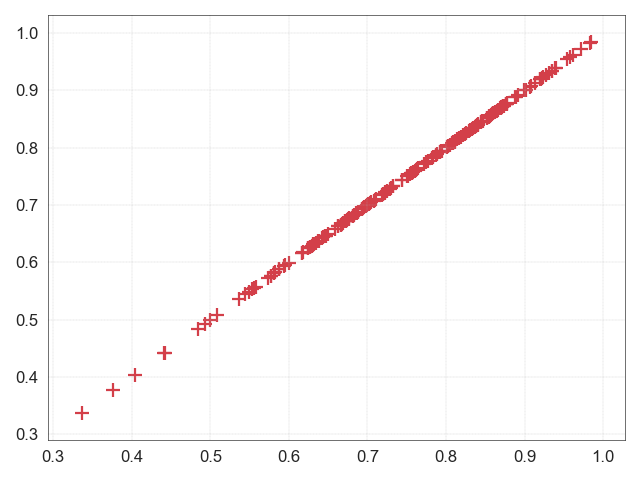

In [35]:
plt.figure()
fids = []
N = 200
dt = 5
for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    #B = np.tensordot(expm(-1j*Z*dt), A, [1, 0])
    B = iMPS().random(2, 2).left_canonicalise()[0]
    #BB = np.tensordot(expm(-1j*Hamiltonian({'ZZ':-1, 'X':1}).to_matrix()*dt), merge(, B), [1, 0])

    E = Map(merge(A, A), merge(B, B))

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()
    #r = np.eye(2)/np.sqrt(2)
    #l = np.eye(2)/np.sqrt(2)

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'R')
    left = put_env_on_right_site(l.conj().T)
    L = Environment(left, 'L')
    
    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    qbs = cirq.LineQubit.range(4)
    normC = cirq.Circuit.from_ops([cirq.H(qbs[1]),
                                   cirq.CNOT(*qbs[1:3]),
                                   L(*qbs[:2]), 
                                   R(*qbs[-2:]),
                                   cirq.CNOT(*qbs[1:3]),
                                   cirq.H(qbs[1])
                                   ])

    s = cirq.Simulator()
    fids.append([np.sqrt(np.abs(s.simulate(C).final_state[0])/np.abs(s.simulate(normC).final_state[0])), np.sqrt(np.abs(x[0]))])
fids = np.array(fids)
plt.scatter(np.abs(fids[:, 0]), np.abs(fids[:, 1]), marker='+');

## Circuit 2: 1 CNOT

<IPython.core.display.Javascript object>


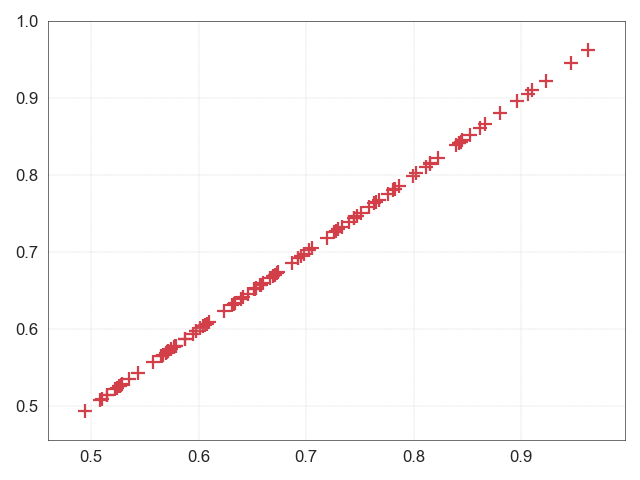

In [184]:
plt.figure()
fids = []
N = 100
dt = 5
WW = expm(-1j*Hamiltonian({'ZZ':-1, 'X':1}).to_matrix()*dt)

for _ in range(N):
    A = iMPS().random(2, 2).left_canonicalise()[0]
    B = A

    E = Map(np.tensordot(WW, merge(A, A), [1, 0]), merge(B, B))

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()
    #r = np.eye(2)/np.sqrt(2)
    #l = np.eye(2)/np.sqrt(2)
    l=r

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(environment_to_unitary(r), 'R')
    L = Environment(put_env_on_right_site(l.conj().T), 'L')
    
    W = Environment(WW, 'W')
    
    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([R(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               W(*qbs[2:4]),
                               L(*qbs[0:2]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    qbs = cirq.LineQubit.range(3)
    normC = cirq.Circuit.from_ops([R(*qbs[1:3]),
                                   L(*qbs[:2]), 
                                   cirq.CNOT(*qbs[1:3]),
                                   cirq.H(qbs[1])
                                   ])
    s = cirq.Simulator()
    ff = np.abs(s.simulate(C).final_state[0])*np.sqrt(2), np.abs(x[0])
    fids.append(ff)
fids = np.array(fids)
plt.scatter(np.abs(fids[:, 0]), np.abs(fids[:, 1]), marker='+');

## Optimization 1: Calculate environment using MPS

In [409]:
from scipy.optimize import minimize
from qmps.represent import ShallowCNOTStateTensor, ShallowQAOAStateTensor

def gate(v, symbol='U'):
    return ShallowCNOTStateTensor(2, v)
    #return ShallowQAOAStateTensor(2, v)
    #return ShallowFullStateTensor(2, v, symbol)
    #return FullStateTensor(U4(v))
    

def obj(p, A, WW):
    B = iMPS([unitary_to_tensor(cirq.unitary(gate(p)))]).left_canonicalise()[0]

    E = Map(np.tensordot(WW, merge(A, A), [1, 0]), merge(B, B))

    x, r = E.right_fixed_point()
    x_, l = E.left_fixed_point()
    l = r

    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    R = Environment(put_env_on_left_site(r), 'θR')
    left = put_env_on_right_site(l.conj().T)
    L = Environment(left, 'θL')
    
    W = Environment(WW, 'W')

    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               W(*qbs[2:4]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
    qbs = cirq.LineQubit.range(4)
    normC = cirq.Circuit.from_ops([cirq.H(qbs[1]),
                                   cirq.CNOT(*qbs[1:3]),
                                   L(*qbs[:2]), 
                                   R(*qbs[-2:]),
                                   cirq.CNOT(*qbs[1:3]),
                                   cirq.H(qbs[1])
                                   ])
    s = cirq.Simulator(dtype=np.complex128)
    ff = np.sqrt(2*np.abs(s.simulate(C).final_state[0]))#/np.abs(s.simulate(normC).final_state[0])), np.sqrt(np.abs(x[0]))
    #print(ff[0]-ff[1])
    #print(ff[0], ff[1])
    return -ff

%autoreload 2
from xmps.iOptimize import find_ground_state
g0, g1 = 1.5, 0.2
A, es = find_ground_state(Hamiltonian({'ZZ':-1, 'X':g0}).to_matrix(), 2, tol=1e-2, noisy=True)
print(es[-1])
lles = []
eevs = []
eers = []
for N in tqdm_notebook(range(16, 2, -2)):

    T = np.linspace(0, 6, 300)
    dt = T[1]-T[0]
    res = minimize(obj, np.random.randn(N), 
                   (A[0], np.eye(4)), 
                   method='Nelder-Mead',
                   options={'disp':False})
    params = res.x
    
    WW = expm(-1j*Hamiltonian({'ZZ':-1, 'X':g1}).to_matrix()*2*dt)
    ps = [params]
    ops = paulis(0.5)
    evs = []
    les = []
    errs = [res.fun]
    for _ in tqdm_notebook(T):
        A_ = iMPS([unitary_to_tensor(cirq.unitary(gate(params)))]).left_canonicalise()
        evs.append(A_.Es(ops))
        les.append(A_.overlap(A))
        res = minimize(obj, params, (A_[0], WW), options={'disp':False})
        params = res.x
        errs.append(res.fun)
        ps.append(params)
    lles.append(les)
    eevs.append(evs)
    eers.append(errs)


  0%|          | 21/5000 [00:00<03:47, 21.92it/s]

(-1.6670232621236283+8.486656421163928e-18j)


<IPython.core.display.Javascript object>


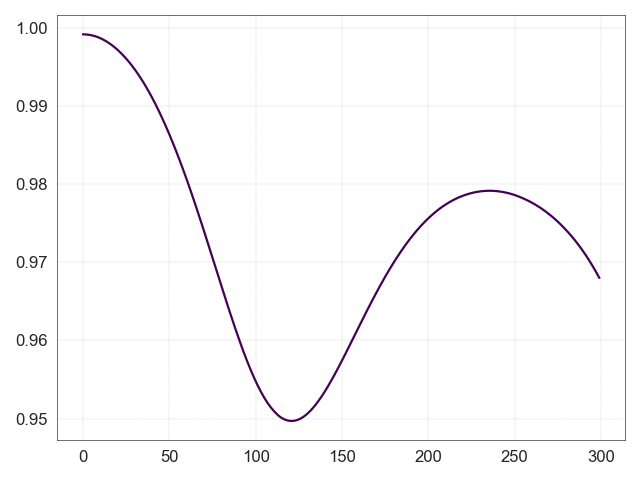

In [410]:
plt.figure()
plt.plot(les)

In [411]:
Q = [loschmidt(t, g0, g1) for t in T]

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/scipy/integrate/quadpack.py:448: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


<IPython.core.display.Javascript object>


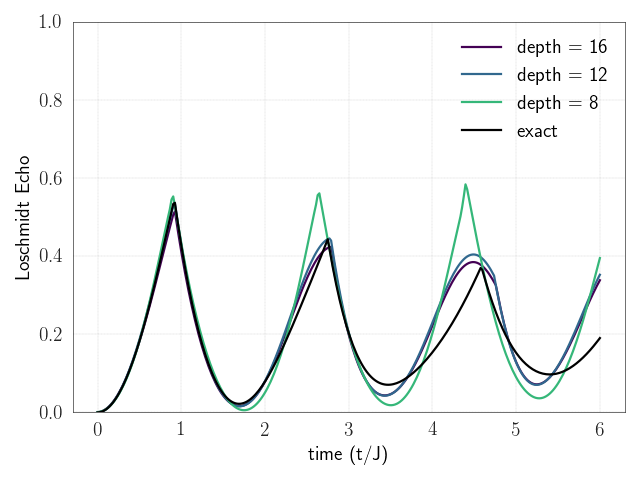

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [436]:
from scipy.integrate import quad
def f(z, g0, g1):
    def theta(k, g):
        return np.arctan2(np.sin(k), g-np.cos(k))/2
    def phi(k, g0, g1):
        return theta(k, g0)-theta(k, g1)
    def epsilon(k, g1):
        return -2*np.sqrt((g1-np.cos(k))**2+np.sin(k)**2)
    def integrand(k):
        return -1/(2*np.pi)*np.log(np.cos(phi(k, g0, g1))**2 + np.sin(phi(k, g0, g1))**2 * np.exp(-2*z*epsilon(k, g1)))

    return quad(integrand, 0, np.pi)[0]


def loschmidt(t, g0, g1):
    return (f(t*1j, g0, g1)+f(-1j*t, g0, g1))

import cycler

n = 4
mpl.style.use("pub_slow")
color = (plt.cm.viridis(np.linspace(0, 1, n)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
#mpl.style.use("pub_fast")
#markers = [':', '--', '-.', ':']*2
markers = ['-']*8
fig, ax = plt.subplots(1, 1, sharex=True)
#ax[0].plot(T, eevs)

for q, i in enumerate(range(16, 4, -4)):
    j = int((16-i)/2)
    ax.plot(T, -np.log(np.array(lles)).T[0][:, j], label='depth = {}'.format(i), linestyle = markers[q])
    ax.set_ylabel('Loschmidt Echo')
#j=8
#ax.plot(T, -np.log(np.array(lles)).T[0][:, j], label='depth = {}'.format(i), linestyle = markers[j])
ax.plot(T, Q, c='black', label='exact')

ax.legend(loc=1)

plt.ylim([0, 1])
#ax[0].set_ylabel('Expectation Values')
ax.set_xlabel('time (t/J)')
plt.savefig('/Users/fergusbarratt/Desktop/Loschmidts_evs.pdf', bbox_inches='tight')

In [31]:
ax[0].plot([x**2 for x in range(5)])

## Optimization 2: Calculate Environment on chip, circuit 1

In [100]:
from scipy.optimize import minimize
from scipy.linalg import norm

def gate(v, symbol='U'):
    #return ShallowCNOTStateTensor(2, v[:-1])
    return ShallowFullStateTensor(2, v, symbol)
    #return FullStateTensor(U4(v))

def obj(p_, A, WW):
    p, rs = p_[:15], p_[15:]
    
    B = iMPS([unitary_to_tensor(cirq.unitary(gate(p)))]).left_canonicalise()[0]
    U = Environment(tensor_to_unitary(A), 'U')
    U_ = Environment(tensor_to_unitary(B), 'U\'')

    r = rotate_to_hermitian((rs[:4]+1j*rs[4:]).reshape(2, 2))
    r /= np.sqrt(np.trace(r.conj().T@r))
    l = r
    
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(l.conj().T), 'L')
    
    W = Environment(WW, 'W')

    qbs = cirq.LineQubit.range(6)
    C = cirq.Circuit.from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]),
                               U(*qbs[2:4]),
                               U(*qbs[1:3]),
                               W(*qbs[2:4]),
                               L(*qbs[0:2]),
                               R(*qbs[4:]),
                               cirq.inverse(U_)(*qbs[1:3]),
                               cirq.inverse(U_)(*qbs[2:4]),
                               cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])

    s = cirq.Simulator(dtype=np.complex128)
    return -np.abs(s.simulate(C).final_state[0])*np.sqrt(2)

T = np.linspace(0, 1, 10)
dt = T[1]-T[0]

WW = expm(-1j*Hamiltonian({'ZZ':-1, 'X':1}).to_matrix()*dt)

ops = paulis(0.5)

ps = [params]
evs = []
les = []

initial_params = np.random.randn(21)
params = initial_params

A = iMPS([unitary_to_tensor(cirq.unitary(gate(params[:15])))]).left_canonicalise()

for _ in tqdm_notebook(T[1:]):
    A_ = iMPS([unitary_to_tensor(cirq.unitary(gate(params[:15])))]).left_canonicalise()
    res = minimize(obj, params, (A_[0], WW), options={'disp':True})
    
    params = res.x
    evs.append(A_.Es(ops))
    les.append(A_.overlap(A))
    
    ps.append(params)

Optimization terminated successfully.
         Current function value: -0.807982
         Iterations: 72
         Function evaluations: 1850
         Gradient evaluations: 74


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


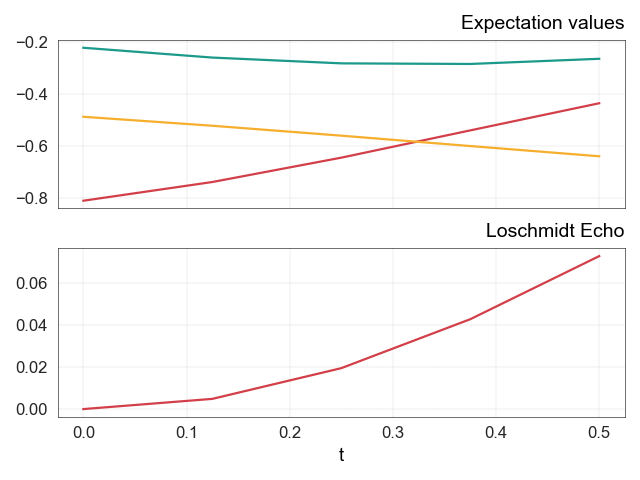

Text(0.5,0,'t')

In [39]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(T, evs)
ax[1].plot(T, -np.log(np.array(les)))
ax[0].set_title('Expectation values', loc='right')
ax[1].set_title('Loschmidt Echo', loc='right')
ax[1].set_xlabel('t')
#plt.savefig('/Users/fergusbarratt/Desktop/evs_les.pdf', bbox_inches='tight')

## Optimization 2: Calculate Environment on chip, circuit 2

<IPython.core.display.Javascript object>


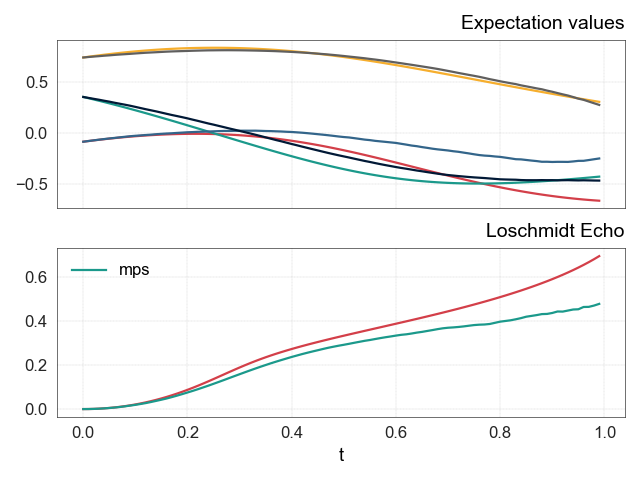

In [272]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(T[:-1], evs)
ax[0].plot(T[:-1], mps_evs)
ax[1].plot(T[:-1], -np.log(np.array(les)))
ax[1].plot(T[:-1], -np.log(np.array(mps_les)), label='mps')
ax[0].set_title('Expectation values', loc='right')
ax[1].set_title('Loschmidt Echo', loc='right')
ax[1].set_xlabel('t')
plt.legend()

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


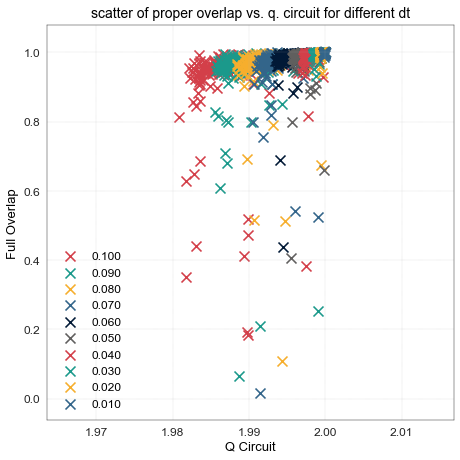

In [34]:
H = Hamiltonian({'ZZ': -1, 'X':1}).to_matrix()
plt.figure()
for dt in tqdm_notebook(np.linspace(0.1, 0.01, 10)):
    cqs = []
    for _ in tqdm_notebook(range(200)):
        U = np.linalg.qr(np.random.randn(4, 4))[0]
        #U_ = U#np.linalg.qr(np.random.randn(4, 4))[0]
        V = get_env_exact(U)
        #V_ = V#get_env_exact(U_)
        A = iMPS([unitary_to_tensor(U)]).left_canonicalise()[0]
        B = iMPS([(A+dt*iMPS([A]).dA_dt([H]).data[0])]).left_canonicalise()[0]

        evo = Environment(expm(-1j*dt*H), 'e^-i*dt*H')
        qbs = cirq.LineQubit.range(4)
        C = cirq.Circuit().from_ops([Environment(V, 'V')(*qbs[2:]), FullStateTensor(U)(*qbs[1:3]), FullStateTensor(U)(*qbs[:2])])
        C.append(evo(*qbs[1:3]))
        C.append([cirq.inverse(Environment(U, 'U')(*qbs[:2])), cirq.inverse(Environment(U, 'U')(*qbs[1:3])), cirq.inverse(Environment(V, 'V')(*qbs[2:]))])
        s = cirq.Simulator()
        ψ = s.simulate(C).final_state
        c = ψ[0]
        q = Map(A, B).left_fixed_point()[0]
        cqs.append([np.abs(c)*2, np.abs(q)**4])
    cqs = np.array(cqs)
    plt.scatter(cqs[:, 0], cqs[:, 1], marker='x', label='{:.3f}'.format(dt));
    plt.xlabel('Q Circuit')
    plt.ylabel('Full Overlap')
#plt.xlim([0, 1.1])
#plt.ylim([0.5, 1.1])
plt.legend(loc=3)
fig = plt.gcf()
fig.set_size_inches(6.5, 6.5)
plt.title('scatter of proper overlap vs. q. circuit for different dt')
plt.savefig('/Users/fergusbarratt/Desktop/overlap_approx.pdf', bbox_inches='tight')

In [270]:
from scipy.optimize import minimize
from scipy.linalg import norm
%autoreload 2
from qmps.represent import StateGate

def gate(v, symbol='U'):
    #return ShallowCNOTStateTensor(2, v[:-1])
    return ShallowFullStateTensor(2, v, symbol)
    #return FullStateTensor(U4(v))
    
def state_gate(v, symbol='R'):
    return StateGate(v, symbol)

def obj(p_, A, WW):
    p, rs = p_[:15], p_[15:]
    
    B = iMPS([unitary_to_tensor(cirq.unitary(gate(p)))]).left_canonicalise()[0]
#     U = Environment(tensor_to_unitary(A), 'U')
#     U_ = Environment(tensor_to_unitary(B), 'U\'')
    
#     #E = Map(np.tensordot(WW, merge(A_[0], A_[0]), [1, 0]), merge(B, B))
#     r_ = E.right_fixed_point()[1]
#     #R = state_gate(rs)
#     #r_ = (rs[:4]+rs[4:]*1j).reshape(2, 2)
#     R = Environment(environment_to_unitary(r_), 'R')
    
#     W = Environment(WW, 'W')
    
#     qbs = cirq.LineQubit.range(5)
#     s = cirq.Simulator(dtype=np.complex128)
    
    E = Map(np.tensordot(WW, merge(A, A), [1, 0]), merge(B, B))
    x, r = E.right_fixed_point()
    return -np.abs(x)

#     v = []
#     for g in [cirq.I, cirq.X, cirq.Y, cirq.Z]:
#         C = cirq.Circuit.from_ops([R(*qbs[3:5]),
#                                    U(*qbs[2:4]),
#                                    U(*qbs[1:3]),
#                                    W(*qbs[2:4]),
#                                    g(qbs[1]),
#                                    cirq.inverse(U_)(*qbs[1:3]),
#                                    cirq.inverse(U_)(*qbs[2:4]),
#                                    cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])
#         v.append(-np.abs(s.simulate(C).final_state[0]))
        
#     return -norm(v)

dt = 1e-2
T_min, T_max = 0, 1
T = np.linspace(T_min, T_max, int((T_max-T_min)/dt)+1)

dt = T[1]-T[0]
H = Hamiltonian({'ZZ':-1, 'X':1}).to_matrix()
WW = expm(-1j*H*dt*2)

ops = paulis(0.5)

ps = [params]
evs = []
les = []

initial_params = np.random.randn(15)
params = initial_params

A = iMPS([unitary_to_tensor(cirq.unitary(gate(params[:15])))]).left_canonicalise()
Q_new = A.copy()

mps_evs = []
mps_les = []

def rk4(mps, dt, H):
    H = H
    k1 = mps.dA_dt([H])*dt
    k2 = (mps+k1/2).dA_dt([H])*dt
    k3 = (mps+k2/2).dA_dt([H])*dt
    k4 = (mps+k3).dA_dt([H])*dt

    return (mps+(k1+2*k2+2*k3+k4)/6).left_canonicalise()

for _ in tqdm_notebook(T[1:]):
    A_ = iMPS([unitary_to_tensor(cirq.unitary(gate(params[:15])))]).left_canonicalise()
    Q = Q_new

    evs.append(A_.Es(ops))
    les.append(A_.overlap(A))
    mps_evs.append(Q.Es(ops))
    mps_les.append(Q.overlap(A))
                   
    res = minimize(obj, params, (A_[0], WW), method='Nelder-Mead', options={'disp':True})
    params = res.x
    ps.append(params)

    Q_new = rk4(Q, dt, H)
    E = Map(np.tensordot(WW, merge(Q[0], Q[0]), [1, 0]), merge(Q_new[0], Q_new[0]))
    x, _ = E.right_fixed_point()
    
    
    print(obj(params, *(A_[0], WW)), np.abs(x))

Optimization terminated successfully.
         Current function value: -0.999942
         Iterations: 295
         Function evaluations: 474
[-0.99994215] [0.99993624]
Optimization terminated successfully.
         Current function value: -0.999944
         Iterations: 358
         Function evaluations: 562
[-0.9999438] [0.999936]
Optimization terminated successfully.
         Current function value: -0.999945
         Iterations: 403
         Function evaluations: 604
[-0.99994542] [0.99993556]
Optimization terminated successfully.
         Current function value: -0.999947
         Iterations: 323
         Function evaluations: 510
[-0.99994702] [0.99994015]
Optimization terminated successfully.
         Current function value: -0.999949
         Iterations: 410
         Function evaluations: 617
[-0.99994859] [0.99993786]
Optimization terminated successfully.
         Current function value: -0.999950
         Iterations: 391
         Function evaluations: 594
[-0.99995014] [0.99994

/Users/fergusbarratt/miniconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


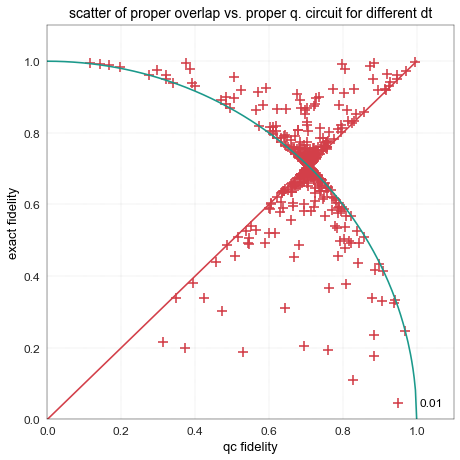

In [5]:
from xmps.spin import paulis
I, X, Y, Z = np.eye(2), *paulis(0.5)
qbs = cirq.LineQubit.range(6)
N = 500
plt.figure()
for dt in tqdm_notebook([0.01]):
    cc = []

    for _ in tqdm_notebook(range(N)):
        A = iMPS().random(2, 2).left_canonicalise()[0]
        B = iMPS([np.tensordot(expm(-1j*Y*dt), A, [1, 0])]).left_canonicalise()[0]
        #B = iMPS().random(2, 2).left_canonicalise()[0]
        
        U = Environment(tensor_to_unitary(A), 'U')
        U_ = Environment(tensor_to_unitary(B), 'U\'')

        E = Map(merge(A, A), merge(B, B))

        x, r = E.right_fixed_point()
        x_, l = E.left_fixed_point()

        L = Environment(put_env_on_right_site(l), 'L')
        R = Environment(put_env_on_left_site(r), 'R')

        U = Environment(tensor_to_unitary(A), 'U')
        U_ = Environment(tensor_to_unitary(B), 'U\'')

        assert np.allclose(get_env_off_left_site(put_env_on_left_site(l, ret_n=False)), l)  # l and r always normalised
        assert np.allclose(get_env_off_right_site(put_env_on_right_site(r, ret_n=False)), r)#


        qbs = cirq.LineQubit.range(6)

        C = cirq.Circuit().from_ops([cirq.H(qbs[3]), cirq.CNOT(*qbs[3:5]), U(*qbs[2:4]), U(*qbs[1:3]), 
                                     L(*qbs[:2]), R(*qbs[-2:]),
                                     cirq.inverse(U_)(*qbs[1:3]), cirq.inverse(U_)(*qbs[2:4]), cirq.CNOT(*qbs[3:5]), cirq.H(qbs[3])])

        #print(C.to_text_diagram(transpose=True))
        s = cirq.Simulator()
        ψ = s.simulate(C).final_state
        #print(ψ)
        cc.append([2*np.abs(ψ[0]), np.abs(x*np.trace(l.conj().T@r))])

    cc = np.array(cc)
    plt.scatter(cc[:, 0], cc[:, 1], marker='+', label='{}'.format(dt))
plt.xlim([0., 1.1])
plt.ylim([0., 1.1])
plt.legend(loc=4)
fig = plt.gcf()
fig.set_size_inches(6.5, 6.5)
plt.title('scatter of proper overlap vs. proper q. circuit for different dt')
#plt.plot(2*cc[:, 0], 2*cc[:, 0], c='black')
x = np.linspace(0, 1, 300)
plt.plot(x, x)
plt.plot(x, np.sqrt(1-x**2))
plt.xlabel('qc fidelity')
plt.ylabel('exact fidelity');

In [589]:
A = iMPS().random(2, 2).left_canonicalise()[0]
B = np.tensordot(expm(-1j*Z*dt), A, [1, 0])

E = Map(A, B)
E_ = Map(merge(A, A), merge(B, B))

In [594]:
E.left_fixed_point()[1]

array([[ 0.76069374+0.j        ,  0.01845563-0.04822254j],
       [ 0.01895358+0.03695733j, -0.5943911 +0.25229575j]])

In [593]:
E_.left_fixed_point()[1]

array([[ 0.76069374+1.38777878e-17j,  0.01845563-4.82225368e-02j],
       [ 0.01895358+3.69573324e-02j, -0.5943911 +2.52295750e-01j]])

In [89]:
a = [1]
a[:-1]

[]

In [90]:
np.prod(a[:-1])

1.0

In [111]:




x = np.random.randn(7)
print(sphere(x), norm(sphere(x)), np.cos(x[0]), np.sin(x[0])*np.cos(x[1]))
raise Exception


[ 0.99419087  0.07393145 -0.06964881  0.02029312 -0.00722806 -0.02752248
 -0.00547303 -0.00402411] 1.0 0.994190874251585 0.07393144688665304


Exception: 

In [162]:
x = np.random.randn(8)
y = np.concatenate([np.random.uniform(0, np.pi, 7), np.random.uniform(0, 2*np.pi)])
print(x/norm(x))

print(Nsphere(x[:-1]))

NameError: name 'pi' is not defined

In [260]:
N = 2
U = np.linalg.qr(np.random.randn(N, N))[0]
A = U@np.diag(np.random.randn(N)+1j*np.random.randn(N))@U.conj().T

In [261]:
A

array([[-1.52782077+0.09051423j,  0.70794663+0.3117473j ],
       [ 0.70794663+0.3117473j , -0.34426151+0.61169957j]])

In [202]:
xs, R = np.linalg.eig(A)
xs_, L = np.linalg.eig(A.T)
print(L.T@R, xs)
#L/=(L.T@R)[0, 0]
#R/=(L.T@R)[0, 0]

[[1. 0.]
 [0. 1.]] [ 1.15740426 -0.8127924 ]


In [201]:
print(L, '\n\n', R)

[[ 0.73817992  0.67460388]
 [-0.67460388  0.73817992]] 

 [[ 0.73817992  0.67460388]
 [-0.67460388  0.73817992]]


In [143]:
xs[0]

-1.7304660843627617

In [192]:
XYZ = np.array(paulis(0.5))
def U(x):
    return expm(-1j*tensordot(x, XYZ, [0, 0]))

minimize(lambda x: (x[:2]@A@x[2:])/np.sum(x[:2].T@x[2:]), np.random.randn(4), method='BFGS')

      fun: -1.7790303051174245
 hess_inv: array([[ 0.98290062, -0.06035855, -0.06534341,  0.02129761],
       [-0.06035855,  0.56022468, -0.16109432, -0.1924002 ],
       [-0.06534341, -0.16109432,  0.78769277,  0.43005608],
       [ 0.02129761, -0.1924002 ,  0.43005608,  1.86750351]])
      jac: array([-0.02715449, -0.34365106,  0.06277467,  0.15216137])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 420
      nit: 2
     njev: 69
   status: 2
  success: False
        x: array([-1.29436642,  0.10227782, -1.50155649,  0.61947205])

In [155]:
x[:2].T@x[2:]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 0 is different from 1)